In [93]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv


df = pd.read_csv('../Datasets/processed_data.csv')
df_advertiser = pd.read_csv('../Datasets/advertiser_embeddings.csv')
df_keywords = pd.read_csv('../Datasets/keyword_embeddings.csv')
df_search_tags = pd.read_csv('../Datasets/search_tag_embeddings.csv')



In [94]:
# Concatenate df_keywords and df_search_tags with the main df along the columns
df = pd.concat([df, df_keywords, df_search_tags], axis=1)

print(df.shape)  # Verify the shape to ensure the merge is correct

(69200, 147)


In [95]:

# Merge embeddings with the main dataset (df) based on advertiser name
df = df.merge(df_advertiser, on="advertiser_name", how="left")

In [96]:
# Define the indices to drop
rows_to_remove = [69130, 69131, 69132, 69133, 69134, 69135]

# Drop the rows
df = df.drop(index=rows_to_remove, errors='ignore')

In [97]:
# The corresponding click values for each record
click_values = torch.tensor(df['clicks'].values, dtype=torch.float)
click_values = click_values.view(-1).float()

# Ensure shapes are appropriate
print(f"clicks shape: {click_values.shape}")

clicks shape: torch.Size([69194])


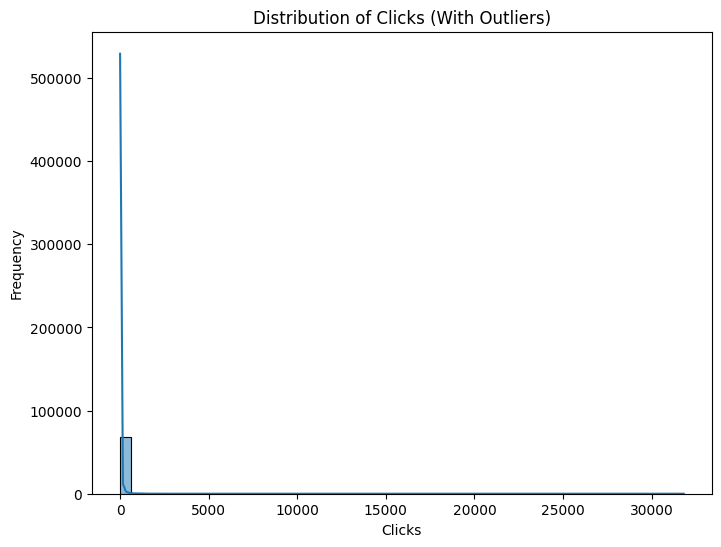

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(click_values, bins=50, kde=True)
plt.title('Distribution of Clicks (With Outliers)')
plt.xlabel('Clicks')
plt.ylabel('Frequency')
plt.show()


In [99]:
import pandas as pd

# Convert to a Pandas Series for easier analysis
click_series = pd.Series(click_values.numpy())

# Descriptive statistics
print(click_series.describe())

# Skewness and Kurtosis
print(f"Skewness: {click_series.skew():.2f}")
print(f"Kurtosis: {click_series.kurt():.2f}")

count    69194.000000
mean        33.410976
std        266.574402
min          2.000000
25%          5.000000
50%          8.000000
75%         11.000000
max      31807.000000
dtype: float64
Skewness: 62.25
Kurtosis: 5790.96


In [100]:
import numpy as np

# Calculate the 95th percentile threshold
threshold = np.percentile(click_values, 95)
print(f"95th Percentile Threshold: {threshold}")

# Filter out the outliers
click_values_filtered = click_values[click_values <= threshold]

# Check the new distribution
print(f"New Max Value: {click_values_filtered.max()}")
print(f"New Shape: {click_values_filtered.shape}")


95th Percentile Threshold: 118.0
New Max Value: 118.0
New Shape: torch.Size([65749])


In [101]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
click_values_normalized = scaler.fit_transform(click_values_filtered.reshape(-1, 1))

print(f"Normalized Click Values (Min-Max): {click_values_normalized.flatten()[:10]}")


Normalized Click Values (Min-Max): [0.05172414 0.36206897 0.25862069 0.39655172 0.15517241 0.07758621
 0.13793103 0.0862069  0.02586207 0.05172414]


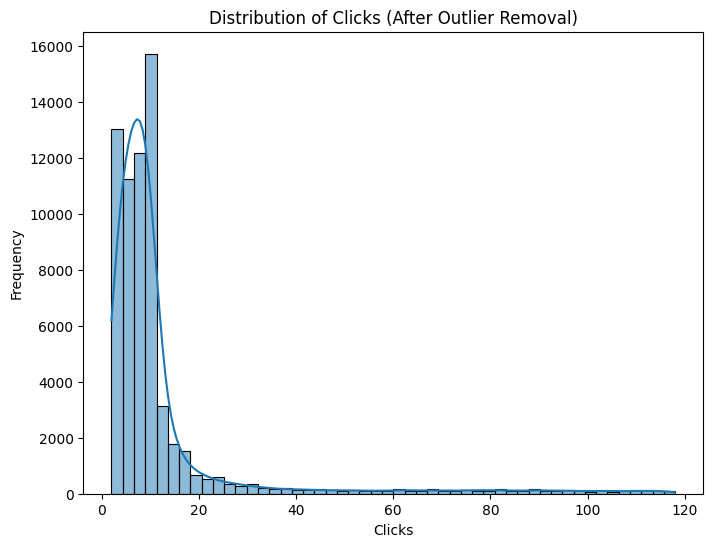

In [102]:
plt.figure(figsize=(8, 6))
sns.histplot(click_values_filtered, bins=50, kde=True)
plt.title('Distribution of Clicks (After Outlier Removal)')
plt.xlabel('Clicks')
plt.ylabel('Frequency')
plt.show()


In [103]:
# Keep only the rows where clicks are below the threshold
df_filtered = df[df['clicks'] <= threshold]
print(f"Filtered Dataset Shape: {df_filtered.shape}")


Filtered Dataset Shape: (65749, 197)


In [104]:
# import numpy as np

# df_filtered['clicks_log'] = np.log1p(df_filtered['clicks'])

# sns.histplot(df_filtered['clicks_log'], bins=50, kde=True)
# plt.title('Distribution of Log-Transformed Clicks')
# plt.xlabel('Log(Clicks)')
# plt.ylabel('Frequency')
# plt.show()

click_values = torch.tensor(df_filtered['clicks'].values, dtype=torch.float)
click_values = click_values.view(-1).float()

# Convert to tensor
click_values = torch.tensor(df_filtered['clicks'].values, dtype=torch.float)
click_values = click_values.view(-1).float()

# Min-Max Normalization
min_val = click_values.min()
max_val = click_values.max()
click_values = (click_values - min_val) / (max_val - min_val)

In [105]:
# Initialize HeteroData object
data = HeteroData()

campaign_data = df_filtered[['campaign_index','no_of_days', 'is_weekday']]
# Convert to tensor format
campaign_features = torch.tensor(campaign_data.values, dtype=torch.float)
# data['campaign'] is the campaign node feature storage
data['campaign'].x = campaign_features


platform_data = df_filtered[['plateform_DV360', 'plateform_Facebook Ads', 'plateform_Google Ads']]
# Convert to tensor format
platform_features = torch.tensor(platform_data.values, dtype=torch.float)
# data['platform'] is the platform node feature storage
data['platform'].x = platform_features


channel_data = df_filtered[['channel_Display', 'channel_Mobile', 
                   'channel_Search', 'channel_Social', 'channel_Video']]
# Convert to tensor format
channel_features = torch.tensor(channel_data.values, dtype=torch.float)
# data['channel'] is the channel node feature storage
data['channel'].x = channel_features


currency_data = df_filtered[['currency_AED', 'currency_EGP', 'currency_INR', 'currency_SGD', 'currency_USD']]
# Convert to tensor format
currency_features = torch.tensor(currency_data.values, dtype=torch.float)
# data['currency'] is the currency node feature storage
data['currency'].x = currency_features


creative_data = df_filtered[['has_image']]
# Convert to tensor format
creative_features = torch.tensor(creative_data.values, dtype=torch.float)
# data['creative'] is the creative node feature storage
data['creative'].x = creative_features


keyword_data = df_filtered[[f'keyword_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Convert to tensor format
keyword_features = torch.tensor(keyword_data.values, dtype=torch.float)
# Store in the data dictionary for keyword nodes
data['keywords'].x = keyword_features


advertiser_id = df_filtered[['advertiser_id']].values  # (69,000, 1)
advertiser_data = df_filtered[[f'advertiser_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Concatenate advertiser_id with the embeddings -> Resulting shape (69,000, 51)
advertiser_features = torch.tensor(np.hstack((advertiser_id, advertiser_data)), dtype=torch.float)
# Assign to the advertiser node in your graph
data['advertiser'].x = advertiser_features


search_tags_data = df_filtered[[f'search_tag_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Convert to tensor format
search_tag_features = torch.tensor(search_tags_data.values, dtype=torch.float)
# Store in the data dictionary for keyword nodes
data['search_tag'].x = search_tag_features

template_data = df_filtered[['template_id']]
# Convert to tensor format
template_features = torch.tensor(template_data.values, dtype=torch.float)
# data['template'] is the template node feature storage
data['template'].x = template_features

network_data = df_filtered[['network_id']]
# Convert to tensor format
network_features = torch.tensor(network_data.values, dtype=torch.float)
# data['network'] is the network node feature storage
data['network'].x = network_features

In [106]:

# Edges (Campaign → Platform)
data['campaign', 'hosted_on', 'platform'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # platform indices
], dtype=torch.long)


data['platform', 'rev_hosted_on', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Campaign → Channel)
data['campaign', 'uses', 'channel'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

data['channel', 'rev_uses', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # channel indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Platform → channel)
data['platform', 'supports', 'channel'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # channel indices
], dtype=torch.long)


# Edges (Campaign → Creative)
data['campaign', 'uses', 'creative'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Creative → Template)
data['creative', 'designed_with', 'template'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # template indices
], dtype=torch.long)


data['campaign', 'associated_with', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['platform', 'optimized_for', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['campaign', 'managed_by', 'network'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['campaign','belongs_to','advertiser'].edge_index = torch.tensor([
    [0, 1],
    [0, 1]
], dtype=torch.long)

# Edges (Campaign → Search Tag)
data['campaign', 'targeted_with', 'search_tag'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # search tag indices
], dtype=torch.long)

data['search_tag', 'rev_targeted_with', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # search tag indices
    [0, 1]   # campaign indices
], dtype=torch.long)


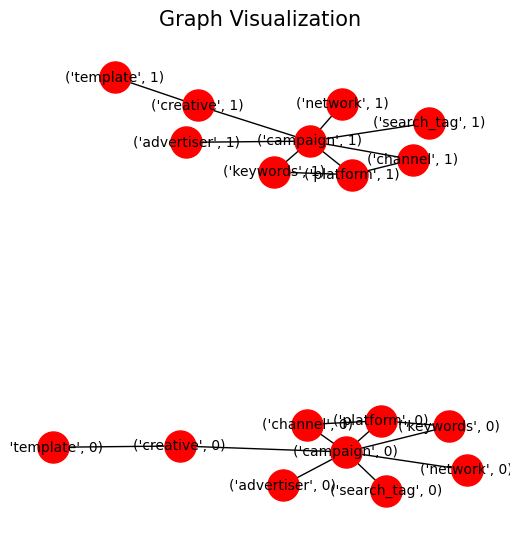

In [108]:
import matplotlib.pyplot as plt
import networkx as nx
import torch

def visualize_graph(data):
    # Create a new graph using NetworkX
    G = nx.Graph()

    # Add nodes and edges to the graph
    for edge_type, edge_index in data.edge_index_dict.items():
        src_type, _, dst_type = edge_type  # Extract source and destination node types
        for src, dst in edge_index.t().tolist():  # Add edges to the graph
            # Add nodes as (node_type, node_id)
            G.add_node((src_type, src))
            G.add_node((dst_type, dst))
            G.add_edge((src_type, src), (dst_type, dst))
    
    # Position nodes using the spring layout (force-directed layout)
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='red', font_size=10)
    plt.title("Graph Visualization", fontsize=15)
    plt.show()

# Visualize the graph
visualize_graph(data)


In [109]:
from torch_geometric.utils import is_undirected, contains_self_loops
from torch.optim.lr_scheduler import StepLR


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the Heterogeneous GCN model
class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        # Define HeteroConv layer with SAGEConv for each relation
        self.conv1 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv((-1, -1), hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv((-1, -1), hidden_dim),
            ('creative', 'designed_with','template'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'managed_by', 'network'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'targeted_with', 'search_tag'): SAGEConv((-1, -1), hidden_dim),
            ('search_tag', 'rev_targeted_with', 'campaign'): SAGEConv((-1, -1), hidden_dim)
        }, aggr="mean")

        self.conv2 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv((-1, -1), hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv((-1, -1), hidden_dim),
            ('creative', 'designed_with','template'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'managed_by', 'network'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'targeted_with', 'search_tag'): SAGEConv((-1, -1), hidden_dim),
            ('search_tag', 'rev_targeted_with', 'campaign'): SAGEConv((-1, -1), hidden_dim)
        }, aggr="mean")

        self.conv3 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv((-1, -1), hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv((-1, -1), hidden_dim),
            ('creative', 'designed_with','template'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'managed_by', 'network'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'targeted_with', 'search_tag'): SAGEConv((-1, -1), hidden_dim),
            ('search_tag', 'rev_targeted_with', 'campaign'): SAGEConv((-1, -1), hidden_dim)
        }, aggr="mean")

        # 🔹 Add LayerNorm for stability
        self.norm1 = torch.nn.LayerNorm(hidden_dim)
        self.norm2 = torch.nn.LayerNorm(hidden_dim)
        self.norm3 = torch.nn.LayerNorm(hidden_dim)

        # Fully connected layer to produce a single output (click value)
        self.fc = torch.nn.Linear(hidden_dim * 7, 1)  # Concatenating features from 6 node types

        

    def forward(self, x_dict, edge_index_dict):

        # 🔹 Apply first convolution
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: self.norm1(x) for key, x in x_dict.items()}  # 🔹 Normalize
        x_dict = {key: F.leaky_relu(x, negative_slope=0.01) for key, x in x_dict.items()}

        # 🔹 Apply second convolution
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: self.norm2(x) for key, x in x_dict.items()}  # 🔹 Normalize
        x_dict = {key: F.leaky_relu(x, negative_slope=0.01) for key, x in x_dict.items()}

        # 🔹 Apply third convolution
        x_dict = self.conv3(x_dict, edge_index_dict)
        x_dict = {key: self.norm3(x) for key, x in x_dict.items()}  # 🔹 Normalize
        
        # Concatenate the features of campaign, platform, and channel for each record
        x_combined = torch.cat([x_dict['campaign'], x_dict['platform'],
                                x_dict['channel'], x_dict['creative'], x_dict['keywords'], 
                                x_dict['search_tag'], x_dict['advertiser']], dim=1)
        
        # Pass through the fully connected layer to get the single click prediction
        out = self.fc(x_combined)
        
        return out


In [110]:
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

# Get indices for campaigns (assuming 'campaign' nodes are being predicted)
campaign_indices = torch.arange(data.x_dict['campaign'].size(0))

# 80% Train, 20% Test Split
train_idx, test_idx = train_test_split(campaign_indices.cpu().numpy(), test_size=0.2, random_state=42)

# Convert to tensors
train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
test_idx = torch.tensor(test_idx, dtype=torch.long, device=device)

In [111]:

# Initialize model
model = HeteroGCN(hidden_dim=32)
print(model)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Reduce LR by 50% every 50 epochs



num_epochs = 80
best_mse = float('inf')
patience = 50
counter = 0

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data (only train nodes)
    out = model(data.x_dict, data.edge_index_dict)
    train_loss = F.mse_loss(out.squeeze()[train_idx], click_values[train_idx])

    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    # 🔹 Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_out = model(data.x_dict, data.edge_index_dict)  # No need for a separate test_data
        test_loss = F.mse_loss(test_out.squeeze()[test_idx], click_values[test_idx])

    test_losses.append(test_loss.item())

    print(f"Epoch {epoch}, Train MSE: {train_loss.item():.4f}, Test MSE: {test_loss.item():.4f}")


HeteroGCN(
  (conv1): HeteroConv(num_relations=13)
  (conv2): HeteroConv(num_relations=13)
  (conv3): HeteroConv(num_relations=13)
  (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=224, out_features=1, bias=True)
)
Epoch 0, Train MSE: 0.0664, Test MSE: 0.3912
Epoch 1, Train MSE: 0.3889, Test MSE: 0.0414
Epoch 2, Train MSE: 0.0415, Test MSE: 0.2320
Epoch 3, Train MSE: 0.2336, Test MSE: 0.2369
Epoch 4, Train MSE: 0.2384, Test MSE: 0.0938
Epoch 5, Train MSE: 0.0946, Test MSE: 0.0332
Epoch 6, Train MSE: 0.0333, Test MSE: 0.0925
Epoch 7, Train MSE: 0.0922, Test MSE: 0.1437
Epoch 8, Train MSE: 0.1435, Test MSE: 0.1151
Epoch 9, Train MSE: 0.1150, Test MSE: 0.0542
Epoch 10, Train MSE: 0.0543, Test MSE: 0.0276
Epoch 11, Train MSE: 0.0278, Test MSE: 0.0490
Epoch 12, Train MSE: 0.0493, Test MSE: 0.0798
Epoch 13, Train MSE: 0.0800,

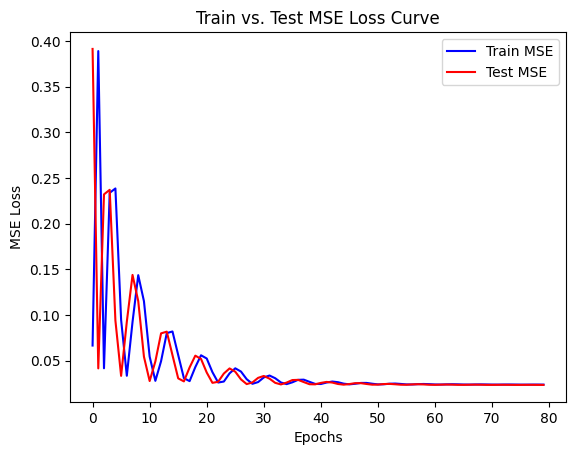

In [112]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, label="Train MSE", color='blue')
plt.plot(range(len(test_losses)), test_losses, label="Test MSE", color='red')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Train vs. Test MSE Loss Curve")
plt.show()


In [113]:
import torch.nn.functional as F

def evaluate_model(model, data, click_values, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation during evaluation
        # Move data to the correct device
        data = data.to(device)
        click_values = click_values.to(device)
        # Forward pass
        out = model(data.x_dict, data.edge_index_dict)
        # Ensure shapes match
        out = out[test_idx]
        click_values = click_values[test_idx]
        # Compute MSE loss between predictions and actual click values
        mse = F.mse_loss(out, click_values)  
        return mse.item()
    
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model
mse_score = evaluate_model(model, data, click_values, device)
print(f"Test MSE: {mse_score:.4f}")


C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_2672\1769999257.py:16: UserWarning: Using a target size (torch.Size([13150])) that is different to the input size (torch.Size([13150, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(out, click_values)


Test MSE: 0.0235


In [114]:
import torch
import torch.nn.functional as F

def r_squared(y_true, y_pred):
    """Calculate the R² (coefficient of determination) score."""
    # Move tensors to CPU and convert to numpy arrays
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    
    # Compute the total sum of squares and residual sum of squares
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    ss_res = ((y_true - y_pred) ** 2).sum()
    
    # Return R² score with safeguard against division by zero
    return 1 - (ss_res / (ss_tot + 1e-8))

# Ensure the model is in evaluation mode
model.eval()

# Move model and data to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data = data.to(device)
click_values = click_values.to(device)

with torch.no_grad():
    # Forward pass on the full dataset
    predictions = model(data.x_dict, data.edge_index_dict).view(-1)
    y_true = click_values.view(-1)
    
    # Apply test indices to avoid data leakage
    predictions = predictions[test_idx]
    y_true = y_true[test_idx]

    # Optional: Check for shape consistency
    assert predictions.shape == y_true.shape, f"Shape mismatch: {predictions.shape} vs {y_true.shape}"

    

# Compute R² score
r2_score = r_squared(y_true, predictions)
print(f"Test R²: {r2_score:.4f}")


Test R²: -0.0076


In [115]:
model.eval()
with torch.no_grad():
    predictions = model(data.x_dict, data.edge_index_dict).squeeze()[test_idx]

print("Actual vs Predicted Clicks:")
for actual, predicted in zip(click_values[test_idx][:10].tolist(), predictions[:10].tolist()):
    print(f"Actual: {actual:.4f}, Predicted: {predicted:.4f}")


Actual vs Predicted Clicks:
Actual: 0.0086, Predicted: 0.0768
Actual: 0.0862, Predicted: 0.0620
Actual: 0.0172, Predicted: 0.1035
Actual: 0.0345, Predicted: 0.0993
Actual: 0.0259, Predicted: 0.0862
Actual: 0.0000, Predicted: 0.1217
Actual: 0.0086, Predicted: 0.0952
Actual: 0.6379, Predicted: 0.0898
Actual: 0.0948, Predicted: 0.1125
Actual: 0.0172, Predicted: 0.0577


In [116]:
# Run model inference
model.eval()
with torch.no_grad():
    output = model(data.x_dict, data.edge_index_dict)

new_campaign_pred = output[-1]  # Assuming last row corresponds to the new campaign
print("Predicted clicks for new campaign:", new_campaign_pred.item())


Predicted clicks for new campaign: 0.07902988791465759


In [ ]:
import torch
import torch.nn.functional as F

def preprocess_input_with_explicit_features(input_data, graph_data, device):
    """
    Converts input data into the format expected by the GNN model, including explicit features.
    """
    processed_data = {}

    # Add explicit features to the processed_data dictionary
    processed_data['platform'] = torch.tensor(input_data.get('platform', []), dtype=torch.float32).to(device)
    processed_data['channel'] = torch.tensor(input_data.get('channel', []), dtype=torch.float32).to(device)
    processed_data['creative'] = torch.tensor(input_data.get('hasimage', []), dtype=torch.float32).to(device)
    processed_data['duration'] = torch.tensor(input_data.get('duration', []), dtype=torch.float32).to(device)
    
    # Add campaign-related features explicitly
    campaign_features = torch.tensor([input_data.get('no_of_days', 0), input_data.get('is_weekday', 0)], dtype=torch.float32).to(device)
    processed_data['campaign'] = campaign_features

    # Return processed data
    return processed_data

def update_graph_with_explicit_features(graph_data, processed_data, device):
    """
    Updates the graph data with explicit features for the new campaign node.
    """
    # Update the graph with the explicit features for the new campaign node (158th campaign)
    graph_data.x_dict['campaign'] = processed_data['campaign']
    graph_data.x_dict['platform'] = processed_data['platform']
    graph_data.x_dict['channel'] = processed_data['channel']
    graph_data.x_dict['creative'] = processed_data['creative']
    graph_data.x_dict['duration'] = processed_data['duration']
    
    return graph_data

def predict_with_explicit_features(input_data, graph_data, model, device):
    """Predicts the clicks for the new campaign, including explicit features."""
    model.eval()
    
    # Process the explicit features for the 158th campaign
    processed_data = preprocess_input_with_explicit_features(input_data, graph_data, device)
    
    # Update the graph data with the explicit features
    graph_data = update_graph_with_explicit_features(graph_data, processed_data, device)

    # Perform inference with the updated graph data and explicit features
    with torch.no_grad():
        output = model(graph_data.x_dict, graph_data.edge_index_dict)

        # Check the shape of the output before indexing
        print("Campaign Output Shape:", output['campaign'].shape)
        
        # Assuming you want the last campaign's prediction (158th)
        new_campaign_pred = output['campaign'][-1]  # Ensure this index is valid based on the output shape
        
    return new_campaign_pred.item()


# Example input with explicit features
input_example = {
    "platform": [1, 0, 0],  # Example platform feature
    "channel": [0, 1, 0, 0, 0],   # Example channel feature
    "creative": [1],        # Example creative feature
    "duration": [32],       # Example campaign duration
    "no_of_days": 10,       # Campaign feature
    "is_weekday": 1         # Campaign feature
}

# Assuming model and graph_data are already defined and loaded
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Make prediction
predicted_clicks = predict_with_explicit_features(input_example, data, model, device)
print("Predicted Clicks for New Campaign:", predicted_clicks)


IndexError: too many indices for tensor of dimension 2

In [ ]:
# torch.save(model.state_dict(), "sage_model.pth")  # ✅ Save only weights
